Test the tracers are working

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from xhistogram.xarray import histogram
from scipy.stats import binned_statistic_2d
import warnings


from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
warnings.filterwarnings('ignore')

run="dpscream_rce_large_3km_aa_default"
ndays=5

run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"

In [2]:
file = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{}/run/{}.eam.h0.2000-01-01-00000.nc".format(run, run)
ds = xr.open_dataset(file).isel(time=slice(-ndays*4,-1)) # chunks={'ncol':50000}
# ds = ds[["NUC","BCU","NI_NUC","W_NUC"]]
# ds.NUC
ds

<xarray.Dataset>
Dimensions:                   (ncol: 147456, lev: 128, ilev: 129, swband: 14,
                               lwband: 16, P3_input_dim: 16, P3_output_dim: 32,
                               time: 19, nbnd: 2)
Coordinates:
  * lev                       (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
  * ilev                      (ilev) float64 2.255 2.905 3.555 ... 997.0 1e+03
  * swband                    (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * lwband                    (lwband) float64 130.0 375.0 ... 2.965e+03
  * P3_input_dim              (P3_input_dim) int32 1 2 3 4 5 ... 12 13 14 15 16
  * P3_output_dim             (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                      (time) object 2000-02-15 06:00:00 ... 2000-02-1...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/232)
    lat                       (ncol) float64 ...
    lon                       (ncol) float64 ...
    area                      (ncol) float64 ...
    hyam                      (lev) float64 ...
    hybm                      (lev) float64 ...
    P0                        float64 ...
    ...                        ...
    crm_grid_x                (time, ncol) float32 ...
    crm_grid_y                (time, ncol) float32 ...
    hstobie_linoz             (time, lev, ncol) float32 ...
    liq_ice_exchange          (time, lev, ncol) float32 ...
    vap_ice_exchange          (time, lev, ncol) float32 ...
    vap_liq_exchange          (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c43cc95a8c
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_6

# altitude-tracer space


In [4]:
tracer = "BCU"
var = "CLDICE"
stat = "mean"
if var=="CLDICE" or var=="Q":
    var_coeff=1000
else:
    var_coeff = 1

bcu = xr.open_dataset(run_dir+run+"_BCU_hrs_last5days.nc").BCU
if var=="NUC":
    nuc = xr.open_dataset(run_dir+run+"_NUC_hrs_last5days.nc").NUC
else:
    nuc = xr.open_dataset(run_dir+run+"_h0_last5days.nc")[var]*var_coeff
print(bcu.shape, nuc.shape)
z = (xr.open_dataset(run_dir+run+".eam.h0.2000-01-01-00000.nc").Z3.isel(time=slice(-21,-1)))/1000
print(z.shape)
binned_stat, x_edges, y_edges, _ = binned_statistic_2d(bcu.values.flatten(),
                                                z.values.flatten(),
                                                nuc.values.flatten(),
                                                statistic=stat,
                                                # bins=[np.logspace(-7,0,100), np.logspace(-7,0,100)])
                                                bins = [np.arange(0,48.1,1), np.linspace(5,20,40)])

# binned_stat, x_edges, y_edges = np.histogram2d(ds['NUC'].values.flatten(),
#                                                ds['BCU'].values.flatten(),
#                                                bins=[np.logspace(-7,0,100), np.logspace(-7,0,100)]
#                                               )
# binned_stat = binned_stat/np.prod(np.shape(ds.NUC))

binned_stat.shape

(20, 128, 147456) (20, 128, 147456)
(20, 128, 147456)


(48, 39)

In [5]:
xmids, ymids = (x_edges[:-1]+x_edges[1:])/2, (y_edges[:-1]+y_edges[1:])/2

xi, yi = np.meshgrid(xmids, ymids)
xi.shape, yi.shape

((39, 48), (39, 48))

In [7]:
units="g/m3"
var, units

('CLDICE', 'g/m3')

saved as plots/bcu_cldice_mean_304ksst.png


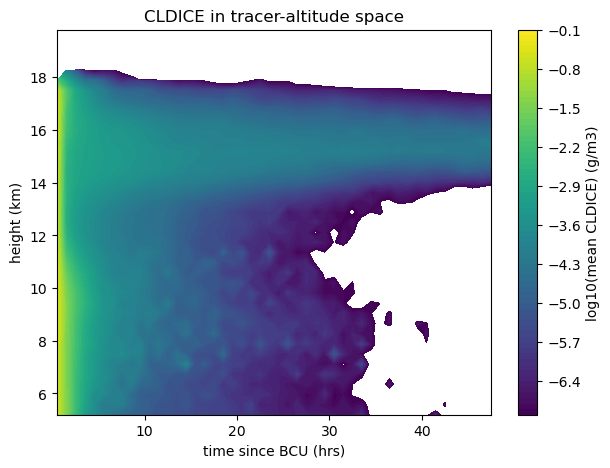

In [8]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
if var=="CLDICE" or var=="Q" or var=="IWC":
    cb_lab = "log10(mean {})".format(var)
    cf = ax.contourf(xi,yi, np.log10(binned_stat.T), levels=np.arange(-7,0,0.1))
elif var=="NI_NUC" or var=="NUMICE":
    cb_lab = "log10(mean {})".format(var)
    cf = ax.contourf(xi,yi, np.log10(binned_stat.T))
elif var=="OMEGA":
    cb_lab = stat+" -"+var
    cf = ax.contourf(xi,yi,(binned_stat.T))
else:
    cb_lab = stat+" "+var
    cf = ax.contourf(xi,yi, (binned_stat.T))
ax.set(xlabel="time since "+tracer+" (hrs)", ylabel="height (km)",
       title=var+" in tracer-altitude space",
       # xscale="log", xlim=[1e-7,1]
      )
# ax.set(xlabel="time since NUC", ylabel="time since BCU", title="tracer-tracer space")
# ax.set(xscale="log", yscale="log", xlim=[1e-7,1], ylim=[1e-7,1])
plt.colorbar(cf, label=cb_lab+f" ({units})", extend='both')
run=run.split("_")[-1]
plt.savefig(f"../plots/large/{tracer.lower()}_{var.lower()}_{stat}_{run}.png")
print(f"saved as plots/{tracer.lower()}_{var.lower()}_{stat}_{run}.png")
plt.show()

# Altitude  Realtive humidity space

In [ ]:
var = "W_NUC"
var_coeff = 1
stat = "mean"
if var=="NUC" or var=="BCU":
    print("tracers")
    binned_stat, x_edges, y_edges, _ = binned_statistic_2d(ds.RELHUM.values.flatten(),
                                    ds.Z3.values.flatten()/1000,
                                    -np.log(ds[var].values.flatten()),
                                    # natural log of variable should give us time since...
                                    statistic=stat,
                                    bins=[np.linspace(0.,110,20), np.linspace(10,20,40)])
elif var[-3:]=="NUC":
    print("extra nuc tracers")
    var_array = np.where(ds.NUC.values.flatten()>1e-5, ds[var].values.flatten(), np.nan)
    binned_stat, x_edges, y_edges, _ = binned_statistic_2d(ds.RELHUM.values.flatten(),
                                    ds.Z3.values.flatten()/1000,
                                    var_array/ds.NUC.values.flatten(),
                                    statistic=stat,
                                    bins=[np.linspace(0.,110,20), np.linspace(10,20,40)])
else:
    print("normal var")
    binned_stat, x_edges, y_edges, _ = binned_statistic_2d(ds.RELHUM.values.flatten(),
                                    ds.Z3.values.flatten()/1000,
                                    ds[var].values.flatten(),
                                    statistic=stat,
                                    bins=[np.linspace(0.,110,20), np.linspace(10,20,40)])
binned_stat.shape

In [ ]:
xmids, ymids = (x_edges[:-1]+x_edges[1:])/2, (y_edges[:-1]+y_edges[1:])/2

xi, yi = np.meshgrid(xmids, ymids)
xi.shape, yi.shape


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
if var=="CLDICE" or var=="Q" or var=="IWC":
    cb_lab = "log10({} {})".format(stat, var)
    cf = ax.contourf(xi,yi, np.log10(binned_stat.T), levels=np.arange(-10,0,0.5))
elif var=="NI_NUC" or var=="W_NUC":
    cb_lab = "({} {}/NUC)".format(stat, var)
    cf = ax.contourf(xi,yi, np.log10(binned_stat.T))
elif var=="NUC":
    cb_lab = "hours since nucleation"
    cf = ax.contourf(xi,yi,(binned_stat.T), levels=np.arange(0,48))
elif var=="BCU":
    cb_lab = "hours since convection"
    cf = ax.contourf(xi,yi,(binned_stat.T), levels=np.arange(0,48))
else:
    cb_lab = stat+" "+var
    cf = ax.contourf(xi,yi, binned_stat.T, levels=20)  #, levels=np.linspace(2000,480000,15)
ax.set(xlabel="RHi", ylabel="height (km)",
       title=var)
# ax.set(xlabel="time since NUC", ylabel="time since BCU", title="tracer-tracer space")
# ax.set(xscale="log", yscale="log", xlim=[1e-7,1], ylim=[1e-7,1])
plt.colorbar(cf, label=cb_lab)
ax.grid(True)
plt.savefig(f"plots/rhi_height_{var.lower()}_{stat}.png")
print(f"saved as plots/rhi_height_{var.lower()}_{stat}.png")
plt.show()

# OMEGA and vertical velocity

In [3]:
# ds = ds[['BCU','OMEGA','OMEGA500']]
ds = ds[['T']]
ds

<xarray.Dataset>
Dimensions:  (time: 19, lev: 128, ncol: 147456)
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 2000-02-15 06:00:00 ... 2000-02-19 18:00:00
Dimensions without coordinates: ncol
Data variables:
    T        (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c43cc95a8c
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_6

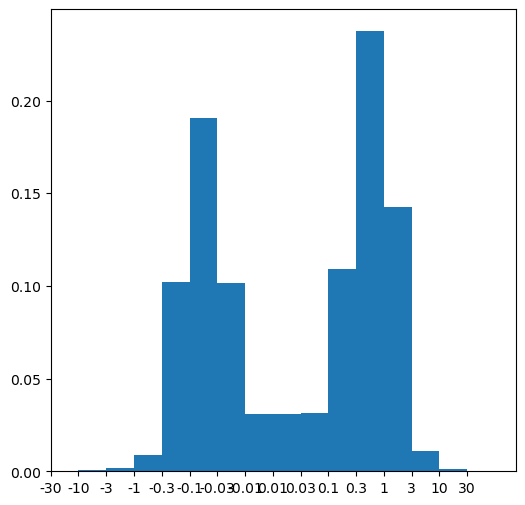

In [5]:
var = "OMEGA500"
fig, ax = plt.subplots(1,1, figsize=(6,6))
bins=(-30,-10,-3,-1,-0.3,-0.1,-0.03,-0.01,0.01,0.03,0.1,0.3,1,3,10,30)
hist, _ = np.histogram(ds[var].values.flatten(), bins=bins)
hist = hist/np.prod(np.shape(ds[var]))
ax.bar(np.arange(len(list(bins))-1), hist, width=1, align='edge')
ax.set(xticks=np.arange(len(list(bins)))-1, xticklabels=bins)
plt.show()


In [ ]:
np.prod(np.shape(ds[var]))

In [6]:
ds[var].quantile(0.1)

<xarray.DataArray 'OMEGA500' ()>
array(-0.32515615)
Coordinates:
    quantile  float64 0.1

In [34]:
omega = ds[var].where(ds[var]<0).quantile(0.1)
omega

<xarray.DataArray 'OMEGA500' ()>
array(-0.49583691)
Coordinates:
    quantile  float64 0.1

In [26]:
ds['T'].values[0,int(np.argmin(abs(ds['T'].lev.values-150)))]


array([201.84517, 201.87766, 201.91878, ..., 201.82536, 201.75247,
       201.81667], dtype=float32)

In [32]:
p = 50000; t = 265
rho = p/(287.05*t)
rho

0.6573044601394142

In [27]:
p = 15000; t = 200
rho = p/(287.05*t)
rho

0.2612785229054172

In [33]:
0.5 / rho * 0.102

0.077589615

In [ ]:
omega = -0.5
rho = ds.lev*100 / (287.05 * ds['T'][0,:,0])
w = - omega / (rho * 9.8)
w

In [7]:
w = 1
rho = ds.lev*100 / (287.05 * ds['T'][0,:,0])
omega = - w * rho * 9.8
omega

<xarray.DataArray (lev: 128)>
array([ -0.03767769,  -0.04530563,  -0.05443118,  -0.0650373 ,
        -0.07776074,  -0.09299696,  -0.10936211,  -0.12747406,
        -0.14930947,  -0.17589287,  -0.20358403,  -0.23334486,
        -0.26687485,  -0.3060389 ,  -0.3521742 ,  -0.40027484,
        -0.44495131,  -0.49548625,  -0.54713788,  -0.60309194,
        -0.66237984,  -0.73235247,  -0.80879857,  -0.88779442,
        -0.95595084,  -1.02511034,  -1.09212766,  -1.16491423,
        -1.24455857,  -1.33251991,  -1.41255342,  -1.47778824,
        -1.53502998,  -1.59108152,  -1.65348427,  -1.71466097,
        -1.78540221,  -1.86461033,  -1.94440694,  -2.02566009,
        -2.10233243,  -2.18136012,  -2.25632752,  -2.33502223,
        -2.41459629,  -2.49342753,  -2.57319006,  -2.6550153 ,
        -2.73867667,  -2.82200683,  -2.90523267,  -2.99085453,
        -3.07946062,  -3.16900476,  -3.25876126,  -3.35052343,
        -3.44673297,  -3.54538697,  -3.64757603,  -3.75272675,
        -3.86136513,  -3.97419021,  -4.08715645,  -4.20379303,
        -4.32621962,  -4.45299849,  -4.58224576,  -4.71497143,
        -4.85705767,  -5.00653872,  -5.16121402,  -5.31773389,
        -5.47921967,  -5.64804969,  -5.82105411,  -5.99606024,
        -6.17754278,  -6.3763442 ,  -6.58675075,  -6.80261389,
        -7.01757813,  -7.22450088,  -7.42559332,  -7.63856437,
        -7.85309942,  -8.05791613,  -8.25838558,  -8.44310626,
        -8.60528182,  -8.76857007,  -8.93301174,  -9.09393741,
        -9.23985883,  -9.38086551,  -9.51847418,  -9.6439882 ,
        -9.76583122,  -9.88628944,  -9.99177862, -10.07800589,
       -10.15137839, -10.22232033, -10.29045677, -10.35528017,
       -10.4240261 , -10.5040652 , -10.5677581 , -10.62102119,
       -10.6712256 , -10.72029511, -10.76834673, -10.81477521,
       -10.85960039, -10.9035313 , -10.94678223, -10.98864515,
       -11.02888856, -11.06804217, -11.10654232, -11.14382614,
       -11.17941741, -11.2136521 , -11.24722641, -11.27976021,
       -11.3105246 , -11.34091966, -11.37302549, -11.40157344])
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
    time     object 2000-02-15 06:00:00

# tracers histograms

In [3]:
file_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
nuc = xr.open_dataset(file_dir+run+"_NUC_hrs_last5days.nc",
                      chunks={'x':2000}).NUC
bcu = xr.open_dataset(file_dir+run+"_BCU_hrs_last5days.nc",
                      chunks={'x':2000}).BCU
temp = xr.open_dataset(file_dir+run+"_h0_last5days.nc",
                      chunks={'x':2000})["T"]
nuc

<xarray.DataArray 'NUC' (time: 20, lev: 128, x: 147456)>
dask.array<open_dataset-NUC, shape=(20, 128, 147456), dtype=float32, chunksize=(20, 128, 2000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-02-15 06:00:00 ... 2000-02-20 00:00:00
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: x
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [4]:
# # -40degC
# nuc = nuc.where(temp<233.15)
# bcu = bcu.where(temp<233.15)
# -60degC
# nuc = nuc.where(temp<213.15)
# bcu = bcu.where(temp<213.15)

In [5]:
# fig, ax = plt.subplots(1,1)
# histogram(bcu, nuc, bins=[np.arange(0,48,0.25),
#                           np.arange(0,48,0.25)],
#          ).plot.contourf()  # norm=mcolors.LogNorm(vmin=1, vmax=1e6)

# plt.savefig("../plots/large/hist_BCU_NUC_tracers_{}_xarray.png".format(run))
# print("... saved.")
# plt.show()

-----------------

Joint BCU-NUC histogram

In [ ]:
print("histogram2d...")
hist, _, _ = np.histogram2d(bcu.values.flatten(), nuc.values.flatten(),
                            bins=[np.arange(0,48,0.25),
                                  np.arange(0,50,0.25)])
hist = hist/np.prod(bcu.shape)
print("done")

histogram2d...
[########################################] | 100% Completed | 4.47 sms
[########################################] | 100% Completed | 5.32 sms


In [ ]:
print("plotting...")
fig, ax = plt.subplots(1,1, figsize=plt.figaspect(0.85), layout='constrained')
xmids = np.arange(0.125,47.75,0.25)
ymids = np.arange(0.125,49.75,0.25)
cf = ax.contourf(xmids, ymids, np.log10(hist.T))
plt.colorbar(cf)
ax.set(xlabel="hours since convection",
       ylabel="hours since nucleation",
       title=run,
       xlim=[0,47.5], ylim=[0,49.5])

plt.savefig("../plots/large/hist_BCU_NUC_tracers_{}.png".format(run))
print("... saved.")
plt.show()

In [ ]:
plot_type='hist'
print("flattening...")
ni_nuc_flat = (ds.NI_NUC/ds.NUC).values.flatten()
print("... done ni_nuc... doing w_nuc...")
w_nuc_flat = (ds.W_NUC/ds.NUC).values.flatten()
print("... done w_nuc...")
if plot_type=='binned_stat':
    print("... doing nuc...")
    nuc_flat = ds.NUC.values.flatten()
    print("... calculating binned stat...")
    stat, xedges, yedges, _ = binned_statistic_2d(ni_nuc_flat,
                                                  w_nuc_flat,
                                                  nuc_flat,
                                                  bins=30
                                                 )
    lab="time since nucleation"
elif plot_type=="hist":
    print("... calculating 2D histogram...")
    stat, xedges, yedges = np.histogram2d(ni_nuc_flat, w_nuc_flat, bins=30)
    lab="2D histogram of ice number and omega tracers"
else:
    print("plot_type not defined")
print("... plotting...")
fig, ax = plt.subplots(1,1)
xmids = (xedges[1:]+xedges[:-1])/2
ymids = (yedges[1:]+yedges[:-1])/2
cf = ax.contourf(xmids, ymids, np.log10(stat))
plt.colorbar(cf)
ax.set(xlabel="ice number", ylabel="omega",
       title=lab
      )
plt.savefig("plots/hist_ni_w_nuc_tracers_{}.png".format(run))
print("... saved.")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1)
var="W_NUC"
ax.hist(np.where(ds.NUC>1e-1, ds[var]/ds.NUC, np.nan).flatten(), bins=20)
ax.set(xlabel="{}/NUC = {} for fresh nucleation".format(var, var.split("_")[0]), ylabel="count", 
       title="histogram {} at fresh nucleation".format( var.split("_")[0]),
       # ylim=[0,1e6]
       yscale="log"
      )
plt.savefig("plots/hist_nuc_{}_tracers_{}.png".format(var, run))
plt.show()

[########################################] | 100% Completed | 4.78 sms


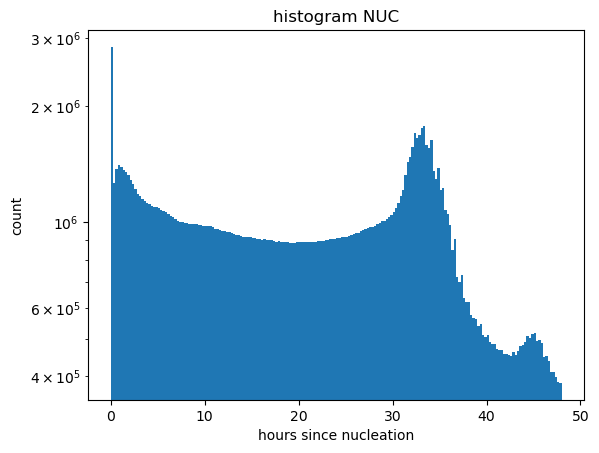

In [5]:
fig, ax = plt.subplots(1,1)
nuc.plot.hist(ax=ax, bins=np.arange(0,48.1,0.25))
ax.set(xlabel="hours since nucleation", ylabel="count", 
       title="histogram NUC",
       yscale="log"
      )
plt.show()

[########################################] | 100% Completed | 4.59 sms


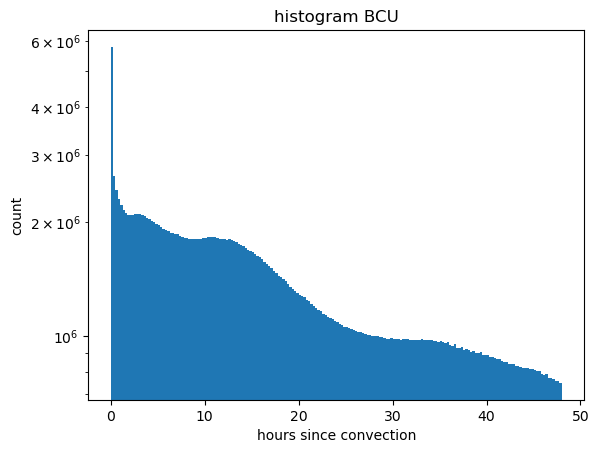

In [6]:
fig, ax = plt.subplots(1,1)
bcu.plot.hist(ax=ax, bins=np.arange(0,48.1,0.25))
ax.set(xlabel="hours since convection", ylabel="count", 
       title="histogram BCU", 
       yscale="log"
      )
plt.show()

In [ ]:
dt = 1
print(ds.W_NUC.mean().values, "mean of W_NUC")
fig, ax = plt.subplots(1,1)
(ds.W_NUC*dt).plot.hist(ax=ax, bins=[-10,-5,-2,-1,1,2,5,10])
ax.set(xlabel="omega at nucleation", ylabel="count", 
       title="", 
       yscale="log"
      )
plt.show()

In [ ]:
dt = 1
print(ds.NI_NUC.mean().values, "mean of NI_NUC")
fig, ax = plt.subplots(1,1)
(ds.W_NUC*dt).plot.hist(ax=ax)
ax.set(xlabel="ice num at nucleation", ylabel="count", 
       title="", 
       yscale="log"
      )
plt.show()

# tracers binned by CRH

In [ ]:
ndays = 5
var="W_NUC"
chunks={'lev':64,'x':2000}
run_dir = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"+\
          "dpscream_rce_large_3km_aa_default/run/"
file = run_dir + f"dpscream_rce_large_default_{var.lower()}_binned_by_crhp.nc"
ds = xr.open_dataset(file)[var]
z = xr.open_dataset(run_dir+"dpscream_rce_large_default.eam.h0.2000-01-01-00000.nc").Z3
z = z.isel(time=slice(-ndays*4,-1)).mean(dim=['time','x'])#.values
z.shape, ds.shape

/glade/derecho/scratch/sturbeville/tmp/ipykernel_43724/2412683850.py:1: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(ds.bins.values, z.values/1000, -np.log(ds.values.T),


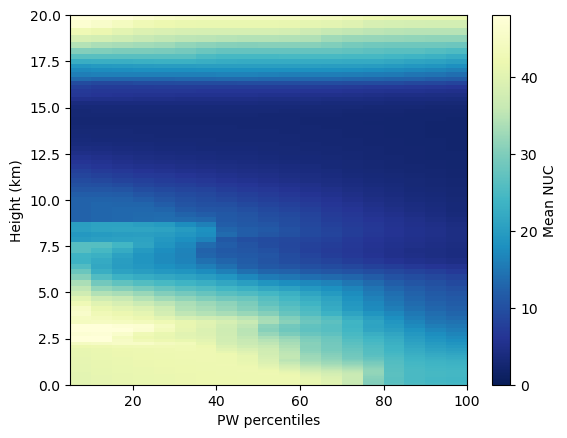

In [4]:
plt.pcolormesh(ds.bins.values, z.values/1000, -np.log(ds.values.T),
               cmap="YlGnBu_r", vmin=0, vmax=48)
plt.ylim([0,20])
plt.xlim([5,100])
plt.colorbar(label=f"Mean {var}")
plt.xlabel("PW percentiles")
plt.ylabel("Height (km)")
plt.savefig(f"../plots/large/{var}_binned_by_crh_percs.png")
plt.show()

In [5]:
ds


<xarray.DataArray 'NUC' (bins: 20, lev: 128)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 3.018893e-11,
        2.800704e-11, 2.723891e-11],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 2.851250e-18,
        2.832452e-18, 2.729294e-18],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.789829e-18,
        1.778029e-18, 1.713273e-18],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.311862e-11,
        1.172465e-11, 1.124443e-11],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 2.339120e-11,
        2.141649e-11, 2.071674e-11],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 3.018893e-11,
        2.800704e-11, 2.723891e-11]])
Coordinates:
  * bins     (bins) float64 2.5 7.5 12.5 17.5 22.5 ... 77.5 82.5 87.5 92.5 97.5
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5

# tracers vertical cross section


In [ ]:
ds.crm_grid_y.values

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12,4))
t = 42
cldice = ds.CLDICE.isel(time=t).mean(dim=["ncol"])
cldice.plot(y="lev", ax=ax[0])
cldice = ds.CLDICE.isel(time=t).mean(dim=["ncol"])
cldice.plot(y="lev")

plt.show()